In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None

        if in_channels != out_channels or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


In [3]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.layer1 = self.make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 32, num_blocks[1], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        layers = [block(self.in_channels, out_channels, stride)]
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self,x):
              out = self.conv1(x)
              out = self.bn1(out)
              out = self.relu(out)

              # Layer 1
              out = self.layer1(out)

              # Layer 2
              out = self.layer2(out)

              out = self.avg_pool(out)
              out = out.view(out.size(0), -1)
              out = self.fc(out)

              return out


In [4]:
def ResNet18():
    return ResNet(ResidualBlock,[2,2])

In [5]:
def train_model(model, trainloader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for data in trainloader:
            inputs, labels = data
            optimizer.zero_grad()  # <-- Corrected line
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

    return model, train_losses, train_accuracies


In [7]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True, transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)
resnet=ResNet18()
criterion=nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9)

resnet,train_losses,train_accuracies = train_model(resnet,trainloader,criterion,optimizer,num_epochs=5)

Files already downloaded and verified
Epoch 1/5, Loss: 1.5376, Accuracy: 42.68%
Epoch 2/5, Loss: 1.1400, Accuracy: 59.03%
Epoch 3/5, Loss: 0.9848, Accuracy: 64.92%
Epoch 4/5, Loss: 0.8984, Accuracy: 68.17%
Epoch 5/5, Loss: 0.8311, Accuracy: 70.52%


Files already downloaded and verified


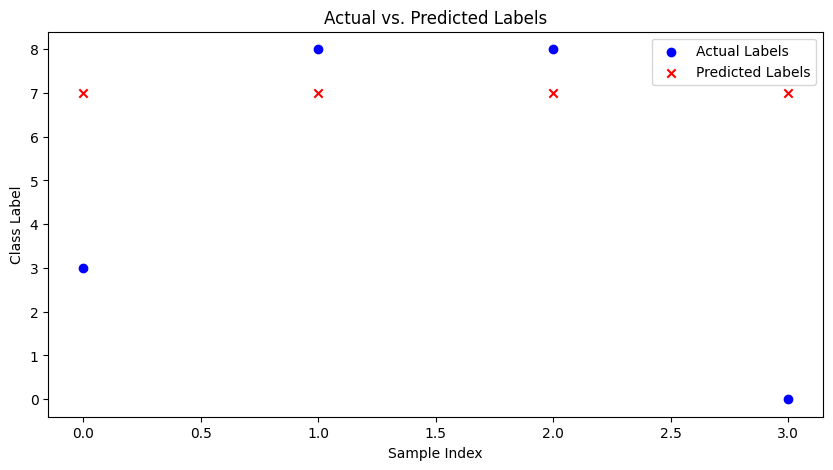

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define your model (replace ResNet18() with the instantiation of your trained model)
model = ResNet18()

# Assuming your model is already trained and you have a batch of test data
# Replace the following lines with your actual test data and DataLoader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

# Get a batch of test data
test_data, test_labels = next(iter(testloader))

# Evaluate the model on the test data
model.eval()
with torch.no_grad():
    outputs = model(test_data)

# Get predicted labels
_, predicted = torch.max(outputs, 1)

# Convert to NumPy arrays for plotting
actual_labels = test_labels.numpy()
predicted_labels = predicted.numpy()

# Plot actual vs. predicted labels
plt.figure(figsize=(10, 5))
plt.scatter(range(len(actual_labels)), actual_labels, label='Actual Labels', color='blue')
plt.scatter(range(len(predicted_labels)), predicted_labels, label='Predicted Labels', color='red', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Class Label')
plt.legend()
plt.title('Actual vs. Predicted Labels')
plt.show()
